Main design workflow file

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json

json_network_path = "./simus/Network.json"
json_network_raw_path = "./simus/Network_raw.json"

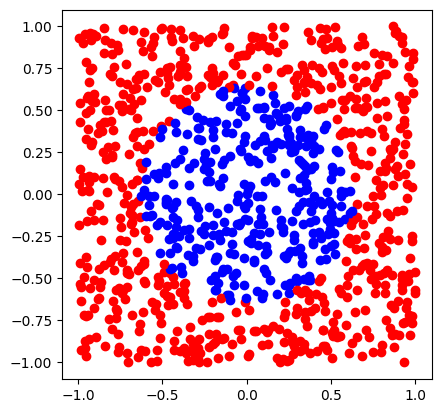

In [2]:
# DEFINE PROBLEM

rho = np.sqrt(2/np.pi)
Ndataset = 10000

X = 1-2*np.random.rand(Ndataset, 2)
Y = np.linalg.norm(X, axis=-1) < rho**2

fig1, ax = plt.subplots()
ax.set_box_aspect(1)

for idx in range(min(1000,Ndataset)):
    if (Y[idx] == 0):
        plt.plot(X[idx][0],X[idx][1],'ro')
    else:
        plt.plot(X[idx][0],X[idx][1],'bo')

In [3]:
# SET TENSORFLOW PARAMETERS

# Load HIDDEN NEURON MODEL

def load_model(path):
    modelfile = open(path)
    model = json.load(modelfile)
    modelfile.close()
    return model

Hexi_model = load_model("simus/NeXon_Hidden_exi_Model.json")
Hinhi_model = load_model("simus/NeXon_Hidden_inhi_Model.json")

def TF_f_h(x):
  xCast = tf.cast(x, tf.float64)
  return (Hexi_model['sigmo'][0]/(1 + tf.math.exp(-Hexi_model['sigmo'][-2]*(xCast-Hexi_model['sigmo'][1]))) + Hexi_model['sigmo'][-1])

HZero = float(TF_f_h(0.5).numpy())

Ksec = 0.8
KsecN = 0.8

Gph_max = Hexi_model['g_bounds'][1]
Gph_min = Hexi_model['g_bounds'][0]
Gnh_max = -Hinhi_model['g_bounds'][0]
Gnh_min = -Hinhi_model['g_bounds'][1]

Bph_max = Gph_max*HZero
Bph_min = Gph_min*HZero
Bnh_max = -Gnh_min*HZero
Bnh_min = -Gnh_max*HZero

# LOAD FIRST LAYER MODEL

Fexi_model = load_model("simus/NeXon_First_exi_Model.json")
Finhi_model = load_model("simus/NeXon_First_inhi_Model.json")

def TF_f_f(x):
  xCast = tf.cast(x, tf.float32)
  return tf.math.polyval(Fexi_model['mod'],xCast)/Hexi_model['k_h'][0]

Gpf_max = Fexi_model['g_bounds'][1]
Gpf_min = Fexi_model['g_bounds'][0]
Gnf_max = -Finhi_model['g_bounds'][0]
Gnf_min = -Finhi_model['g_bounds'][1]

class FirstLayerComposition(tf.keras.layers.Layer):
    def __init__(self):
        super(FirstLayerComposition, self).__init__()

    def call(self, inputs):
        return TF_f_f(inputs)

class Betweenbias(tf.keras.constraints.Constraint):
    def __call__(self, w):        
        return tf.keras.backend.clip(tf.cast(w, tf.float32), tf.cast(Bnh_min, tf.float32), tf.cast(Bph_max, tf.float32))

class BetweenGainH(tf.keras.constraints.Constraint):
    def __init__(self):
        pass
    def __call__(self, w): 
        return tf.keras.backend.clip(tf.cast(w, tf.float32), tf.cast(-Gnh_max*KsecN, tf.float32),tf.cast(Gph_max*Ksec, tf.float32))
    
class BetweenGainHandSum(tf.keras.constraints.Constraint):
    def __init__(self):
        pass
    def __call__(self, w): 
        # first, bounds
        wclip = tf.keras.backend.clip(tf.cast(w, tf.float32), tf.cast(-Gnh_max*KsecN, tf.float32),tf.cast(Gph_max*Ksec, tf.float32))
        # second, sum
        sums = tf.keras.backend.sum(wclip, axis = 0)
        scale = tf.keras.backend.maximum(1.0, tf.keras.backend.abs(sums/1.5))
        return wclip/scale

class BetweenGainF(tf.keras.constraints.Constraint):
    def __init__(self):
        pass
    def __call__(self, w): 
        return tf.keras.backend.clip(tf.cast(w, tf.float32), tf.cast(-Gnf_max*KsecN, tf.float32),tf.cast(Gpf_max*Ksec, tf.float32))

print("Gain bounds H :",Gph_max,Gph_min,Gnh_max,Gnh_min)
print("Gain bounds F :",Gpf_max,Gpf_min,Gnf_max,Gnf_min)
print("Bias bounds : ",Bnh_min,Bph_max)
print("Bias current out :",HZero*Hexi_model['k_h'][0])
print("Bias current out normalized:",HZero)
print("Bias current in :",0.5*Hexi_model['k_h'][0])
print("Parameters loaded")

Gain bounds H : 1.0 0.11510829365431888 0.8288243334786765 0.549901204904334
Gain bounds F : 1.0000000000000002 0.38149337934633804 0.5757155510687109 0.19899949243243598
Bias bounds :  -0.7894931712258032 0.952545840337728
Bias current out : 1.905091680675456e-10
Bias current out normalized: 0.952545840337728
Bias current in : 1e-10
Parameters loaded


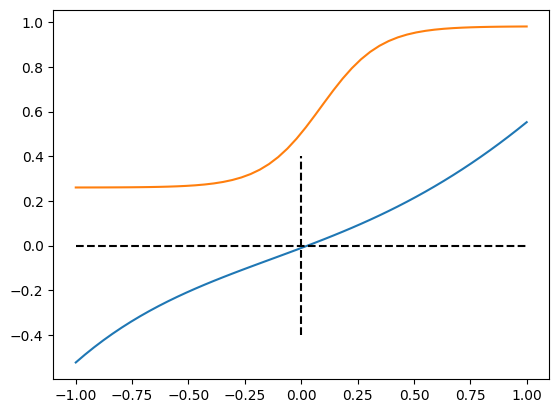

In [4]:
# DRAW ACTIVATION FUNCTIONS

xtf = tf.constant(np.linspace(-1,1), dtype = tf.float32)

plt.plot(xtf.numpy(), TF_f_f(xtf))
plt.plot([-1,1],[0,0],'k--')
plt.plot([0,0],[-0.4,0.4],'k--')
plt.plot(xtf.numpy(), TF_f_h(xtf))
plt.show()

In [5]:
# LEARNING PROCEDURE

def create_and_train_model(nb_epochs=30):
    print("Launch Training...")
    model = tf.keras.models.Sequential()

    model.add(FirstLayerComposition())
    model.add(tf.keras.layers.Dense(4, activation=TF_f_h, kernel_constraint=BetweenGainF(), bias_constraint=Betweenbias()))#, kernel_initializer=initializer))
    model.add(tf.keras.layers.Dense(4, activation=TF_f_h, kernel_constraint=BetweenGainHandSum(), bias_constraint=Betweenbias()))
    model.add(tf.keras.layers.Dense(1, activation='linear', kernel_constraint=BetweenGainHandSum(), bias_constraint=Betweenbias()))

    loss_fn = tf.losses.MeanSquaredError()
    model.compile(optimizer='adam',loss=loss_fn,metrics=['accuracy'])
    fit = model.fit(X, Y, epochs=nb_epochs, verbose=0)
    print("... Training done")
    return model, fit

#model, history = create_and_train_model()

In [6]:
# Save model and plot accuracy

def save_model(model, path='./tf/tf_run'):
    model.save(path)

    """acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b--', label='Training acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.plot(epochs, loss, 'b--', label='Training loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()"""

#save_model(model)

In [7]:
# SEE RESULTS
Ngrid = 20

def see_results(model):
    qaxis = np.linspace(-1,1,Ngrid)
    Xpredict = [[qaxis[i], qaxis[j]] for i in range(Ngrid) for j in range(Ngrid)]
    Ypredict = model.predict(Xpredict)

    Ypredict2 = np.reshape(Ypredict, (Ngrid,Ngrid))
    delta = np.max(Ypredict2) - np.min(Ypredict2)
    print("Interval : ^=",delta)

    plt.title("TensorFlow network, ^="+str(round(delta,3)))
    plt.imshow(Ypredict2)
    plt.show()

    return Xpredict, Ypredict

"""mmax = np.max(Ypredict)
for x in range(len(Xpredict)):
    col = float(Ypredict[x]/mmax)
    plt.plot(Xpredict[x][0],Xpredict[x][1], 'o', color=(col,col,col))
plt.show()"""

#Xpredict, Ypredict = see_results(model)

"mmax = np.max(Ypredict)\nfor x in range(len(Xpredict)):\n    col = float(Ypredict[x]/mmax)\n    plt.plot(Xpredict[x][0],Xpredict[x][1], 'o', color=(col,col,col))\nplt.show()"

In [8]:
# Vérification que l'on peut bien reproduire les résultats de tf
def syn_numpy_from_tf(Xpredict, model):
    Ypredict = model.predict(Xpredict)
    Ypredict = np.reshape(Ypredict, (Ngrid,Ngrid))

    fig, axs = plt.subplots(1,2, figsize=(9, 6))

    axs[0].imshow(Ypredict)
    axs[0].set_title("Tf output")

    def get_numpy_model(model):
        NumpyModel = []
        for idx, layer in enumerate(model.layers, 0):
            if (idx == 0):
                continue
            W = layer.get_weights()[0]
            B = []
            if (len(layer.get_weights()) > 1):
                B = layer.get_weights()[1]
                NumpyModel.append({'W':W,'B':B})
            else:
                NumpyModel.append({'W':W})
        return NumpyModel

    def numpy_model_predict(Xpredict, NumpyModel, out_layer=None, out_idx=0):
        if (out_layer == None):
            out_layer = len(NumpyModel)
        Ynumpy = []
        for x in Xpredict:
            # compute pred
            vec = x
            for layer in range(len(NumpyModel)+1):

                if (layer == out_layer):
                    #pass
                    Ynumpy.append(vec[out_idx])
                    break

                if (layer == len(NumpyModel)):
                    break

                if (layer == 0):
                    vec = TF_f_f(tf.constant(vec, dtype = tf.float32)).numpy()
                else:
                    vec = TF_f_h(tf.constant(vec, dtype = tf.float32)).numpy()

                vec = np.matmul(np.transpose(NumpyModel[layer]['W']),vec)

                if ('B' in NumpyModel[layer]):
                    vec += NumpyModel[layer]['B']
                    pass

                if (layer == len(NumpyModel)-1):
                    pass
                #else:
                #    vec = TF_f_h(tf.constant(vec, dtype = tf.float32)).numpy()
            #Ynumpy.append(vec[out_idx])

        return np.array(Ynumpy)

    NumpyModel = get_numpy_model(model)
    Ynumpy = numpy_model_predict(Xpredict, NumpyModel)
    Ynumpy = np.reshape(Ynumpy, (Ngrid,Ngrid))

    axs[1].imshow(Ynumpy)
    axs[1].set_title("numpy output")

    plt.show()

#syn_numpy_from_tf(Xpredict,model)

In [9]:
# On regarde l'image d'une coupe

"""time = np.linspace(0,0.001,40)
Xslice = np.array([[i,0] for i in np.linspace(-1,1,len(time))])


Ynumpy_c1 = numpy_model_predict(Xslice, NumpyModel,3,0)

print("weight input layer :",model.layers[1].get_weights())

plt.title("Slice by numpy")
#plt.plot(time, Ynumpy_b0, label="b0")
#plt.plot(time, Ynumpy_b1, label="b1")

plt.plot(time, Ynumpy_c1, label="c.")
plt.legend()
plt.show()"""

'time = np.linspace(0,0.001,40)\nXslice = np.array([[i,0] for i in np.linspace(-1,1,len(time))])\n\n\nYnumpy_c1 = numpy_model_predict(Xslice, NumpyModel,3,0)\n\nprint("weight input layer :",model.layers[1].get_weights())\n\nplt.title("Slice by numpy")\n#plt.plot(time, Ynumpy_b0, label="b0")\n#plt.plot(time, Ynumpy_b1, label="b1")\n\nplt.plot(time, Ynumpy_c1, label="c.")\nplt.legend()\nplt.show()'

In [10]:
# Save Raw weight as external json

def get_syn_name(layer_id, j, layer_id_target, i):
    return chr(ord('a') + layer_id) + str(j) + "_" + chr(ord('a') + layer_id_target) + str(i)

def extract_Tfkernel(conn_dic, layer_id, W):
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            conn_dic[get_syn_name(layer_id, i, layer_id + 1, j)] = {'TFw':float(W[i,j])}

def extract_Tfbias(conn_dic, layer_id, B):
    for i in range(B.shape[0]):
        conn_dic[get_syn_name(0, 0, layer_id+1, i)] = {'TFw':float(B[i]),'TFb':float(B[i])}

def save_model_weights_as_json(model, path = json_network_raw_path):
    connTf_dic = {}
    for layer_id, layer in enumerate(model.layers):
        if (len(layer.weights) == 0):
            continue
        W, B = layer.weights
        extract_Tfkernel(connTf_dic, layer_id, W.numpy())
        extract_Tfbias(connTf_dic, layer_id, B.numpy())

    with open(path, "w") as write_file:
        json.dump(connTf_dic, write_file, indent=4)

#save_model_weights_as_json(model)

In [11]:
# EXPORT WEIGHTS

HZeroLow = float(TF_f_h(-0.5).numpy()) # a0
HZeroHigh = float(TF_f_h(0.5).numpy()) # a1

# Define leak model
Fexi_leak_mod = np.poly1d(Fexi_model['b_fct_w'])
Finhi_leak_mod = np.poly1d(Finhi_model['b_fct_w'])
Hexi_leak_mod = np.poly1d(Hexi_model['b_fct_w'])
Hinhi_leak_mod = np.poly1d(Hinhi_model['b_fct_w'])

id_first_layer = 1 # puisque composition en 0

def get_tuple_from_name(name):
    split = name.split('_')
    return (ord(split[0][0])-ord('a'), int(split[0][1:]),ord(split[1][0])-ord('a'), int(split[1][1:]))

def smartClip(x, xnmin, xn_max, xpmin, xpmax, log):
    v = _smartClip(x, xnmin, xn_max, xpmin, xpmax)
    if abs(v - x) > 0.1 and log:
        print("cliped",x,"->",v)
    return v

def _smartClip(x, xnmin, xn_max, xpmin, xpmax):
    # Clip to 0 if smart
    # xnmin, xn_max < 0
    if x < 0:
        if x > xn_max:
            if (np.abs(x - xn_max) < np.abs(x)):
                return xn_max
            else:
                return 0
        else:
            return np.clip(x, xnmin, xn_max)
    else:
        if x < xpmin:
            if (np.abs(x - xpmin) < np.abs(x)):
                return xpmin
            else:
                return 0
        else:
            return np.clip(x, xpmin, xpmax)

def get_W_of_G(Gtf, firstLayer, log=False):
    global exi_model, inhi_model, Fexi_model, Finhi_model
    if firstLayer:
        G = smartClip(Gtf, -Gnf_max, -Gnf_min, Gpf_min, Gpf_max, log)
        if (G > 0):
            return np.poly1d(Fexi_model['w_fct_g'])(G)
        if (G < 0):
            return np.poly1d(Finhi_model['w_fct_g'])(G)
        return G
    else:
        G = smartClip(Gtf, -Gnh_max, -Gnh_min, Gph_min, Gph_max, log)
        if (G > 0):
            return np.poly1d(Hexi_model['w_fct_g'])(G)
        if (G < 0):
            return np.poly1d(Hinhi_model['w_fct_g'])(G)
        return G
    
def get_G_of_W(W, firstLayer, exitation):
    global Hexi_model, Hinhi_model, Fexi_model, Finhi_model
    if (W == 0):
        return 0
    if firstLayer:
        if exitation:
            return np.poly1d(Fexi_model['g_fct_w'])(W)
        else:
            return np.poly1d(Finhi_model['g_fct_w'])(W)
    else:
        if exitation:
            return np.poly1d(Hexi_model['g_fct_w'])(W)
        else:
            return np.poly1d(Hinhi_model['g_fct_w'])(W)
    
def get_leak_of_W(W, firstLayer, exitation):
    global Hexi_model, Hinhi_model, Fexi_model, Finhi_model
    if firstLayer:
        if exitation:
            return np.poly1d(Fexi_model['b_fct_w'])(W)
        else:
            return np.poly1d(Finhi_model['b_fct_w'])(W)
    else:
        if exitation:
            return np.poly1d(Hexi_model['b_fct_w'])(W)
        else:
            return np.poly1d(Hinhi_model['b_fct_w'])(W)
        
def get_W_of_Gget_W_bias(bias, HZero):
    return get_W_of_G(bias/HZero, False)

def get_syn_name(layer_id, j, layer_id_target, i):
    return chr(ord('a') + layer_id) + str(j) + "_" + chr(ord('a') + layer_id_target) + str(i)

def extract_gain(conn_dic, syn_tupple, W, log):
    # compute size
    w = get_W_of_G(W, syn_tupple[0] == id_first_layer, log)
    #gphy = get_G_of_W(w, syn_tupple[0] == id_first_layer, W > 0)
    #print("Extract",get_syn_name(*syn_tupple),"G phy:",round(gphy,3),"Gtf:",round(W,3),"Abs diff =",abs(gphy-W))
    # save result
    if syn_tupple[0] != id_first_layer:
        block_name = "NeXon_Hidden_Psyn" if W > 0 else "NeXon_Hidden_Nsyn"
        block_name = "NeXon_Hidden_Nosyn" if w == 0 else block_name
        param_name = "W"
    else:
        block_name = "NeXon_First_Psyn" if W > 0 else "NeXon_First_Nsyn"
        block_name = "NeXon_First_Nosyn" if w == 0 else block_name
        param_name = "Lr"
    conn_dic[get_syn_name(*syn_tupple)] = {'CDS':{'param':{param_name: w}, "block_name": block_name}, 'TFw':float(W)}

def extract_syn_bias(conn_dic, syn_tupple, B, log):
    # first, look witch bais neuron (high or low) to use
    w_low_err = abs(get_G_of_W(get_W_of_G(B/HZeroLow, False, log), False, B > 0) - B/HZeroLow)
    w_high_err = abs(get_G_of_W(get_W_of_G(B/HZeroHigh, False, log), False, B > 0) - B/HZeroHigh)
    err = 0
    # choose wich synapse to use :
    if (w_low_err < w_high_err):
        w = get_W_of_G(B/HZeroLow, False)
        bias_neuron = 0
        err = w_low_err
        HZeroBiasNeuron = HZeroLow
    else:
        w = get_W_of_G(B/HZeroHigh, False)
        bias_neuron = 1
        err = w_high_err
        HZeroBiasNeuron = HZeroHigh
    if log:
        print("err:",err)
    block_name = "NeXon_Hidden_Psyn" if B > 0 else "NeXon_Hidden_Nsyn"
    block_name = "NeXon_Hidden_Nosyn" if w == 0 else block_name
    conn_dic[get_syn_name(syn_tupple[0],bias_neuron,syn_tupple[2],syn_tupple[3])] = {'CDS':{'param':{"W": w}, "block_name": block_name}, 'TFw':float(B/HZeroBiasNeuron),'TFb':float(B) }

def get_leak_of_neuron(conn_dic, neuron_layer, neuron_idx):
    # seach synapse going to (neuron_layer, neuron_idx)
    total_leak = 0
    for syn in conn_dic:
        syn_tupple = get_tuple_from_name(syn)
        if (syn_tupple[-2] == neuron_layer) and (syn_tupple[-1] == neuron_idx):# and (syn_tupple[0] != 0):
            leak = 0
            pos = False
            if (syn_tupple[0] == id_first_layer):
                wphi = conn_dic[syn]['CDS']['param']['Lr']
                if (conn_dic[syn]['CDS']['block_name'] == "NeXon_First_Psyn"):
                    pos = True
                    leak = Fexi_leak_mod(wphi)
                elif(conn_dic[syn]['CDS']['block_name'] == "NeXon_First_Nsyn"):
                    leak = Finhi_leak_mod(wphi)
            else:
                wphi = conn_dic[syn]['CDS']['param']['W']
                if (conn_dic[syn]['CDS']['block_name'] == "NeXon_Hidden_Psyn"):
                    pos = True
                    leak = Hexi_leak_mod(wphi)
                elif(conn_dic[syn]['CDS']['block_name'] == "NeXon_Hidden_Nsyn"):
                    leak = Hinhi_leak_mod(wphi)
            total_leak += leak
            #print("leak from",syn,"(wphi=",wphi,"), l =",leak,"exitation =",pos)
    return total_leak


def update_bias_with_leak(conn_dic, syn, total_leak):
    new_bias = conn_dic[syn]['TFw']*HZero - total_leak/Hexi_model['k_h'][0]
    ori = conn_dic[syn]['CDS']['param']['W']
    extract_syn_bias(conn_dic, get_tuple_from_name(syn), new_bias)
    print(ori,"-->",conn_dic[syn]['CDS']['param']['W'])
    

def generate_physical_sizing_from_tf(path_=json_network_raw_path, log=False):
    # Load Raw weights
    rawfile = open(path_)
    rawdic = json.load(rawfile)
    rawfile.close()
    # Connection dictionary :
    conn_dic = {}
    
    for syn in rawdic:
        syn_tupple = get_tuple_from_name(syn)
        if (syn_tupple[0] == 0):
            # it's bias
            extract_syn_bias(conn_dic, syn_tupple, rawdic[syn]['TFb'], log)
        else:
            # it's gain
            extract_gain(conn_dic, syn_tupple, rawdic[syn]['TFw'], log)

    #print("Extraction done. Start leak compensation")
    """for syn in conn_dic:
        syn_tupple = get_tuple_from_name(syn)
        if (syn_tupple[0] == 0):
            # it's bias. Get all leak of the target neuron
            total_leak = get_leak_of_neuron(conn_dic, syn_tupple[-2],syn_tupple[-1])
            print(syn,"Total leak=",total_leak,'normalized:',total_leak/Hexi_model['k_h'][0])
            #update_bias_with_leak(conn_dic, syn, total_leak)"""

    with open(json_network_path, "w") as write_file:
        json.dump(conn_dic, write_file, indent=4)
    #print("Extraction saved at",json_network_path)

#generate_physical_sizing_from_tf(json_network_raw_path, True)

In [12]:
# AUTOMATIC CADENCE SCHEMATIC TESTING
from CDS_Synthesis import *
import csv

history_save_path = "./automatic_synthesis/history.csv"
Ngrid_simu = 20

def save_history_in_csv(runNumber, history, ImgNetwork, conso_max, conso_in_max, max_acc, seuil_max_acc, separation, path=history_save_path):
    acc = history.history['accuracy']
    loss = history.history['loss']
    with open(path, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([runNumber,len(acc),conso_max, conso_in_max, max_acc, seuil_max_acc, separation] + list(acc)+list(loss)+list(ImgNetwork.flatten()))

def get_perfect_img(Ngrid):
        def in_ref(x):
                return 2*x/(Ngrid-1) - 1
        TargetImg = np.zeros((Ngrid,Ngrid))
        for x in range(Ngrid):
                for y in range(Ngrid):
                        if (np.sqrt(in_ref(x)**2 + in_ref(y)**2) < rho**2):
                                TargetImg[x,y] = 1
        return TargetImg

TargetImg = get_perfect_img(Ngrid_simu)

def get_accuracy(ImgNetwork, TargetImg):
        vrai_positif = np.logical_and(TargetImg, ImgNetwork)
        vrai_négatif = np.logical_and(np.logical_not(TargetImg), np.logical_not(ImgNetwork))
        return (np.sum(vrai_positif)+np.sum(vrai_négatif))/(vrai_positif.shape[0]**2)

def get_max_accuracy(ImgNetwork, TargetImg):
        # Return the accuracy for the optimal treashold
        max_acc = 0
        seuil_max_acc = 0
        max_ = np.max(ImgNetwork)
        min_ = np.min(ImgNetwork)
        for i in np.linspace(0,1,20):
                # On coupe 
                level_ = min_ + i*(max_ - min_)
                ImgNetwork_cut = np.where(ImgNetwork < level_, np.zeros_like(ImgNetwork), np.ones_like(ImgNetwork))
                acc = get_accuracy(ImgNetwork_cut, TargetImg)
                if (acc > max_acc):
                        max_acc = acc
                        seuil_max_acc = i
        return max_acc, seuil_max_acc

def synthesis_init():
    return build_simulator()

def synthesis_flow(simulator, runNumber, nb_epochs=30, display=False):
    model, history = create_and_train_model(nb_epochs=nb_epochs)
    #save_model(model)
    save_model_weights_as_json(model)
    generate_physical_sizing_from_tf(json_network_raw_path, False)
    print("Launch CDS...")
    ImgNetwork, conso_max, conso_in_max = compute_square(simulator, Ngrid_simu, display)
    max_acc, seuil_max_acc = get_max_accuracy(ImgNetwork, TargetImg)
    print("... CDS done")
    separation = np.max(ImgNetwork) - np.min(ImgNetwork)
    save_history_in_csv(runNumber, history, ImgNetwork, conso_max, conso_in_max, max_acc, seuil_max_acc, separation)
    if (display):
        plt.show()
        plt.imshow(ImgNetwork)
        plt.show()
    return {'img':ImgNetwork, 'conso_max':conso_max, 'conso_in_max':conso_in_max, 'max_acc':max_acc, 'max_acc_level':seuil_max_acc, 'separation':separation, 'model':model}
    

ModuleNotFoundError: No module named 'stplibV6'

In [ ]:
# THE SYNTHESIS CODE

1/0

def cds_synthesis_score(run_cds_dic):
    if (run_cds_dic['max_acc'] < 0.7):
        return 0
    if (run_cds_dic['conso_max']*1e9 > 5):
        return 0
    if (run_cds_dic['separation'] > 1000):
        return 0
    return run_cds_dic['max_acc'] - run_cds_dic['conso_max']*1e8 + run_cds_dic['separation']/800

best_score = 0
best_score_acc = 0
best_score_sep = 0
best_score_conso = 0
Nruns = 1000
Num_run_start = 0
simulator = synthesis_init()

for nrun in range(Num_run_start, Nruns+Num_run_start):
    run_cds_dic = synthesis_flow(simulator, nrun, 30, False)
    score = cds_synthesis_score(run_cds_dic)
    print("RUN N°",nrun+1,"/",Nruns,"===============================")
    if (score > best_score):
        print(" ------------------- ")
        print("BEST SCORE HIT... SAVE WEIGHT")
        save_model_weights_as_json(run_cds_dic['model'], "./simus/Network_best_score.json")
        save_model(run_cds_dic['model'])
        best_score = score
        best_score_acc = run_cds_dic['max_acc']
        best_score_conso = run_cds_dic['conso_max']
        best_score_sep = run_cds_dic['separation']
        print(" ------------------- ")
    print("max acc =",round(run_cds_dic['max_acc'],3)," (best =",round(best_score_acc,3),")")
    print("separation =",round(run_cds_dic['separation'],3)," (best =",round(best_score_sep,3),")")
    print("conso_max =",round(run_cds_dic['conso_max']*1e9,3)," (best =",round(best_score_conso*1e9,3),")")
    print("score =",round(score,3)," (best =",round(best_score,3),")")
    print()

print()
print("===============================")
print("SYNTHESIS DONE")
print("Best score = ",best_score)
print("Best score acc = ",best_score_acc)
print("Best score conso = ",best_score_conso)
print("Best score separation = ",best_score_sep)
print("===============================")


Launch Training...
... Training done
Launch CDS...
... CDS done
RUN N° 751 / 250 ===============================
max acc = 0.738  (best = 0 )
separation = 22.456  (best = 0 )
conso_max = 1.291  (best = 0.0 )
score = 0.637  (best = 0.917 )

Launch Training...
... Training done
Launch CDS...
... CDS done
RUN N° 752 / 250 ===============================
max acc = 0.698  (best = 0 )
separation = 34.774  (best = 0 )
conso_max = 1.447  (best = 0.0 )
score = 0  (best = 0.917 )

Launch Training...
... Training done
Launch CDS...
... CDS done
RUN N° 753 / 250 ===============================
max acc = 0.728  (best = 0 )
separation = 20.605  (best = 0 )
conso_max = 1.37  (best = 0.0 )
score = 0.616  (best = 0.917 )

Launch Training...
... Training done
Launch CDS...
... CDS done
RUN N° 754 / 250 ===============================
max acc = 0.698  (best = 0 )
separation = 38.27  (best = 0 )
conso_max = 1.289  (best = 0.0 )
score = 0  (best = 0.917 )

Launch Training...
... Training done
Launch CDS...

In [ ]:
# On récupère les param du meilleur run

#save_model(model)

"""generate_physical_sizing_from_tf("./simus/Network_best_score copy.json", False)
print("Launch CDS...")
param = load_network_sizing()
ImgNetwork, conso_max, conso_in_max = compute_square(simulator, Ngrid_simu, True)
max_acc, seuil_max_acc = get_max_accuracy(ImgNetwork, TargetImg)
traces = compute_traces(-0.1, 0.1, 0, simulator, param, log = False)"""


'generate_physical_sizing_from_tf("./simus/Network_best_score copy.json", False)\nprint("Launch CDS...")\nparam = load_network_sizing()\nImgNetwork, conso_max, conso_in_max = compute_square(simulator, Ngrid_simu, True)\nmax_acc, seuil_max_acc = get_max_accuracy(ImgNetwork, TargetImg)\ntraces = compute_traces(-0.1, 0.1, 0, simulator, param, log = False)'

In [17]:
# extract the tensorflow accuracy from json

model = tf.keras.models.load_model("./tf/tf_run")



NameError: name 'rmse' is not defined